# Double Dueling Deep Q-Newtork for Ms Pacman v0

In [17]:
import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
from torchsummary import summary
import os


In [2]:
def select_device(device=''):
    if device.lower() == 'cuda':
        if not torch.cuda.is_available():
            print ("torch.cuda not available")
            return torch.device('cpu')    
        else:
            return torch.device('cuda:0')
    if device.lower() == 'dml':
        return torch.device('dml')
    else:
        return torch.device('cpu')

In [3]:
env = gym.make('MsPacman-v0')

In [18]:
AGENT_COLOR = np.array([210, 164, 74]).mean()
N_ACTION = env.action_space.n
N_EPISODE = 5000
LEARNING_RATE = 0.001
LAMBDA = .99
UPDATE_TARGET_STEP = 1000
BATCH_SIZE = 64
MAX_STEP = 50000
CAPACITY_BUFFER = 10000
DEVICE = 'dml'

skip_steps = 90  # waiting steps MsPacman-v0 

In [5]:
def preprocess(state):
    state = state[1:176:2, ::2,:].mean(axis=2) # downsample and to gray
    state [ state==AGENT_COLOR] = 0
    state = (state-128)
    return state

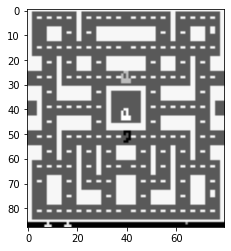

In [6]:
obs = env.reset()
state = preprocess(obs)
plt.imshow(state, cmap='gray')

In [7]:
#=====REPLAY BUFFER
class ReplayBuffer:
    def __init__(self, capacity, device):
        self.capacity = capacity
        self.size = 0
        self._offset = 0
        # 5 : (state, action, reward, new_state, is_done)
        self.buffer = np.zeros(shape=(capacity, 5), dtype=np.ndarray)
        self.device = device

    def __len__(self):
        return self.size

    def add(self, experience:tuple):
        """
        experience is tuple of ndarray
        """
        self.buffer[self._offset] = experience
        self._offset = (self._offset+1)%self.capacity
        self.size = min(self.size+1, self.capacity)

    def sample(self, batch_size):
        """
        to torch.tensor
        """
        s, a, r, ss, d = self._sample(batch_size)
        s = torch.from_numpy(s).float().to(self.device)
        a = torch.from_numpy(a).long().to(self.device)
        r = torch.from_numpy(r).float().to(self.device)
        ss = torch.from_numpy(ss).float().to(self.device)
        d = torch.from_numpy(d).float().to(self.device)
        return (s, a, r, ss, d)

    def _sample(self, batch_size):
        """
        get samples
        """
        idxes = np.random.choice(self.size, batch_size, replace=False)
        experiences = np.vstack(self.buffer[idxes, 0]), np.vstack(self.buffer[idxes, 1]), np.vstack(self.buffer[idxes, 2]), np.vstack(self.buffer[idxes, 3]), np.vstack(self.buffer[idxes, 4])
        return experiences


#=====Action Strategies
class ExponentialDecayEGreedyStrategy:
    def __init__(self, start_epsilon=1., end_epsilon=0.1, decay_steps=2000):
        self.step = 0
        self.start_e = start_epsilon
        self.end_e = end_epsilon
        self.decay_steps = decay_steps

    def reset(self):
        self.step = 0

    def _epsilon(self):
        i = self.step 
        self.step+=1
        exp_e = self.start_e* np.power(0.005, (i / self.decay_steps))
        return exp_e * (self.start_e- self.end_e) + self.end_e

    def select_action(self, model, state):
        with torch.no_grad(): 
            pred = model(state).cpu().detach().numpy()
            action = np.argmax(pred) if np.random.rand() > self._epsilon() else np.random.randint(len(pred))
        return action

class GreedyActionStrategy:
    def reset(self): pass

    def select_action(self, model, state):
        with torch.no_grad(): 
            pred = model(state).cpu().detach().numpy()
            action = np.argmax(pred) 
        return action


#=====Network
class DuelingNetwork(nn.Module):
    def __init__(self, output_dim):
        super().__init__()
        self.conv_layers = nn.Sequential(
            # conv layers
            nn.Conv2d(1, 32, 8, 4),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, 1),
            nn.ReLU(),
            nn.Flatten(),
        )
        self.fc_layer = nn.Sequential(
            # fc layers
            nn.Linear(3072, 512),
            nn.ReLU(),
        )
        self.value = nn.Linear(512, 1)
        self.action = nn.Linear(512, output_dim)


    def forward(self, state):
        # x = self.preprocess_state(state)
        x = self.conv_layers(state)
        x = self.fc_layer(x)
        a = self.action(a)
        v = self.value(x)

        # # dim of value ouptut is 1. need to expand
        v = v.expand_as(a)
        q = v + a - a.mean(1, keepdim=True).expand_as(a)
        return q


In [29]:
class DQNAgent:
    def __init__(self, env, model_fn, model_arg, train_strategy, eval_strategy, device, skip_steps=0):
        self.env = env
        self.target = model_fn(*model_arg).to(device)
        self.online = model_fn(*model_arg).to(device)
        self.update_network()

        self.train_strategy = train_strategy
        self.eval_strategy = eval_strategy
        self.batch = ReplayBuffer(CAPACITY_BUFFER, device)
        self.device = device

        self.game_skip = skip_steps

    
    def update_network(self):
        """
        update the online network into target network
        """
        self.target.load_state_dict(self.online.state_dict())

    def optimize(self, experiences, optim):
        with torch.no_grad():
            states, actions, rewards, next_states, is_dones = experiences
            ## double
            max_a_index = self.online(self.preprocess_state(next_states)).detach().argmax(1)
            max_a_q_value = self.target(self.preprocess_state(next_states)).gather(1, max_a_index.unsqueeze(1))
            target_q_value = rewards + (LAMBDA* max_a_q_value * (1 - is_dones))

        q_value = self.online(self.preprocess_state(states)).gather(1, actions)
        # td_error = q_value -  target_q_value
        optim.zero_grad()
        value_loss = nn.MSELoss()(q_value, target_q_value)
        value_loss.backward()
        optim.step()
 

    def preprocess_state(self, state): 
        """
        convert into the torch
        """
        state = torch.tensor(state, device=self.device, dtype=torch.float32)
        return state.unsqueeze(1)

    def train(self, n_episode, optim_fn, lr):
        optim = optim_fn(self.online.parameters(), lr = lr)
        buffer = ReplayBuffer(CAPACITY_BUFFER, self.device)
        import time
        
        start_time = time.time()

        for e in range(n_episode):
            state = preprocess(env.reset())
            step_count = 0
            # skip the waiting steps
            for _ in range(self.game_skip):
                new_state, reward, is_done, _ = self.env.step(0)
                state = preprocess(new_state)

            episode_total_reward = 0
            while True:
                action = self.train_strategy.select_action(self.online, state)
                # get new state and reward from environment
                new_state, reward, is_done, _ = self.env.step(action)
                new_state = preprocess(new_state)

                experience = (state, action, reward, new_state, is_done)
                buffer.add(experience)

                if len(buffer) > BATCH_SIZE:
                    experiences = buffer.sample(BATCH_SIZE)
                    self.optimize(experiences, optim)

                    step_count += 1
                    episode_reward += reward
                    state = new_state

                    if step_count % UPDATE_TARGET_STEP == 0:
                        self.update_network()

                if is_done or step_count>=MAX_STEP:
                    # terminate the episode
                    print('\tepisode: {}/{}  | total reward : {:.3f} | elapsed time: {:.3f}'.format(e+1, n_episode, episode_total_reward, (time.time() - start_time))//60)
                    break
            pass
            if e % 1000 == 0:
                self.target.save('ddqn_pacman_{}.pth'.format(e))
        pass

    def save(self, filepath):
        torch.save(self.target.state_dict(), filepath)

    def load(self, filepath):
        state_dict = torch.load(filepath)
        self.target.load_state_dict(state_dict)
        self.online.load_state_dict(state_dict)


In [30]:
device = select_device('dml')
# device = select_device('cuda')

In [31]:
agent = DQNAgent(env, DuelingNetwork, (N_ACTION,), GreedyActionStrategy(), ExponentialDecayEGreedyStrategy(1, 0.1, 20000),device, skip_steps)

In [32]:
## TRAIN
agent.train(N_EPISODE, Adam, LEARNING_RATE)

AttributeError: 'DuelingNetwork' object has no attribute 'device'